In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

from tools import DATADIR, F1_ZIPPED
from etl.ergast import ErgastF1
from viz.graph import Graph
from viz.plot import Plot

f1 = ErgastF1(F1_ZIPPED)
plot = Plot()

Autosave disabled


In [2]:
from itertools import permutations
from pandas import DataFrame, Series

## Who raced with whom?
Count races for each (driver, driver) pair of teammates.

In [3]:
mates = (
    f1.results['id_driver id_race id_team'.split()]
    .join(f1.races['season race'.split()], on='id_race')
#    .loc[lambda df: df['season'].ge(1990)]
    .join(f1.drivers['driver'], on='id_driver')
    .join(f1.teams['team'], on='id_team')
    .groupby('season race team'.split())
    ['driver'].apply(lambda s: list(permutations(s, 2)))
    .explode()
)
mates = DataFrame(mates.tolist(),index = mates.index)
mates.columns = 'source target'.split()
mates

source            target
season race                     team                                         
1950   Belgian Grand Prix       Alfa Romeo      Juan Fangio     Luigi Fagioli
                                Alfa Romeo      Juan Fangio       Nino Farina
                                Alfa Romeo    Luigi Fagioli       Juan Fangio
                                Alfa Romeo    Luigi Fagioli       Nino Farina
                                Alfa Romeo      Nino Farina       Juan Fangio
...                                                     ...               ...
2019   United States Grand Prix Renault     Nico Hülkenberg  Daniel Ricciardo
                                Toro Rosso     Daniil Kvyat      Pierre Gasly
                                Toro Rosso     Pierre Gasly      Daniil Kvyat
                                Williams     George Russell     Robert Kubica
                                Williams      Robert Kubica    George Russell

[40420 rows x 2 columns]

In [4]:
graph = Graph(mates)
graph

Graph with 9988 links
              source                 target  weight
0       Adolf Brudes            Fritz Riess       1
1       Adolf Brudes             Hans Klenk       1
2       Adolf Brudes           Josef Peters       1
3       Adolf Brudes           Paul Pietsch       1
4       Adolf Brudes          Theo Helfrich       1
...              ...                    ...     ...
9983  Óscar González             Jean Behra       1
9984  Óscar González  José Froilán González       1
9985  Óscar González           Luigi Piotti       1
9986  Óscar González          Mike Hawthorn       1
9987  Óscar González          Stirling Moss       1

[9988 rows x 3 columns]

## doppelgänger

In [5]:
doppels = (
    graph.links.nlargest(40,'weight').iloc[::2]
    .set_index('source target'.split())
    ['weight'].rename('races').reset_index()
)
doppels

,source,target,races
0,Michael Schumacher,Rubens Barrichello,104
1,David Coulthard,Mika Häkkinen,99
2,Mark Webber,Sebastian Vettel,94
3,Kimi Räikkönen,Sebastian Vettel,81
4,Lewis Hamilton,Nico Rosberg,78
5,Felipe Massa,Fernando Alonso,77
6,Gerhard Berger,Jean Alesi,77
7,Jenson Button,Rubens Barrichello,70
8,Elio de Angelis,Nigel Mansell,62
9,Kevin Magnussen,Romain Grosjean,62


## brundling

In [6]:
def bacon_distance(graph, core):
    
    nodes = graph.nodes
    source = graph.links['source']
    target = graph.links['target']
    degree = Series(-1, index=nodes)

    nextgen = {core}
    for i in range(100):
        degree[nextgen] = i
        marked = set(nodes[degree.gt(-1)])
        nextgen = set(target[source.isin(nextgen)]) - marked
        if not nextgen:
            return degree
        
core = 'Martin Brundle'
degree = bacon_distance(graph, core)
print(f"{degree.eq(0).sum()} {core}")
print(f"{degree.eq(-1).sum()} not connected")
print(f"{degree.gt(0).sum()} within {degree.max()} degrees")
degree[degree.lt(0)]

1 Martin Brundle
11 not connected
789 within 7 degrees


Bayliss Levrett     -1
Bernie Ecclestone   -1
Bill Cantrell       -1
Bruce Kessler       -1
Ernie de Vos        -1
Geoff Crossley      -1
Joe Kelly           -1
Jules Bianchi       -1
Max Chilton         -1
Paul Emery          -1
Peter Broeker       -1
dtype: int64

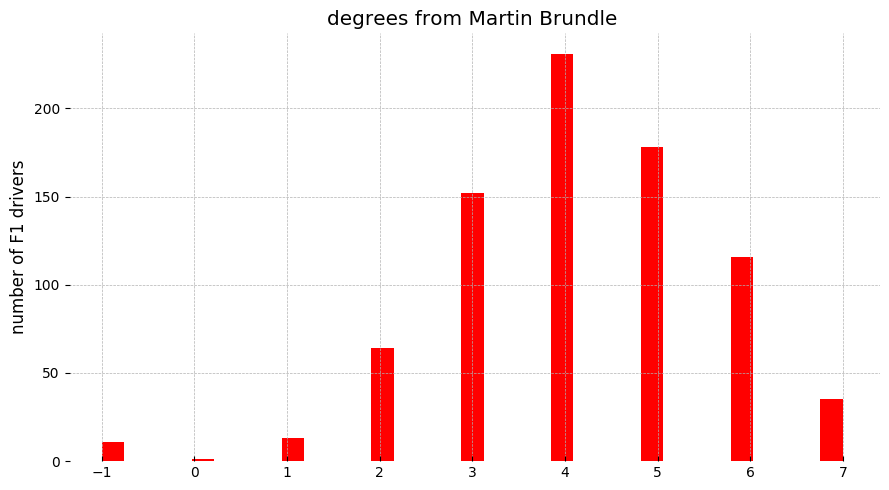

In [7]:
def showdegree(graph, core, **kwargs):
    degree = bacon_distance(graph, core)

    kwargs.setdefault('color', 'r')
    kwargs.setdefault('legend', False)
    kwargs.setdefault('title', f"degrees from {core}")
    kwargs.setdefault('ylabel', 'number of F1 drivers')
    plot.hist(degree, **kwargs)

showdegree(graph, 'Martin Brundle')

## use the force

In [8]:
core = 'Martin Brundle'
frame = graph.frame()
frame['degree'] = bacon_distance(graph, core)
frame['size'] = graph.links.groupby('source')['weight'].sum()
frame['size'] *= 64 / frame['size'].mean()
frame = frame.sort_values('size')

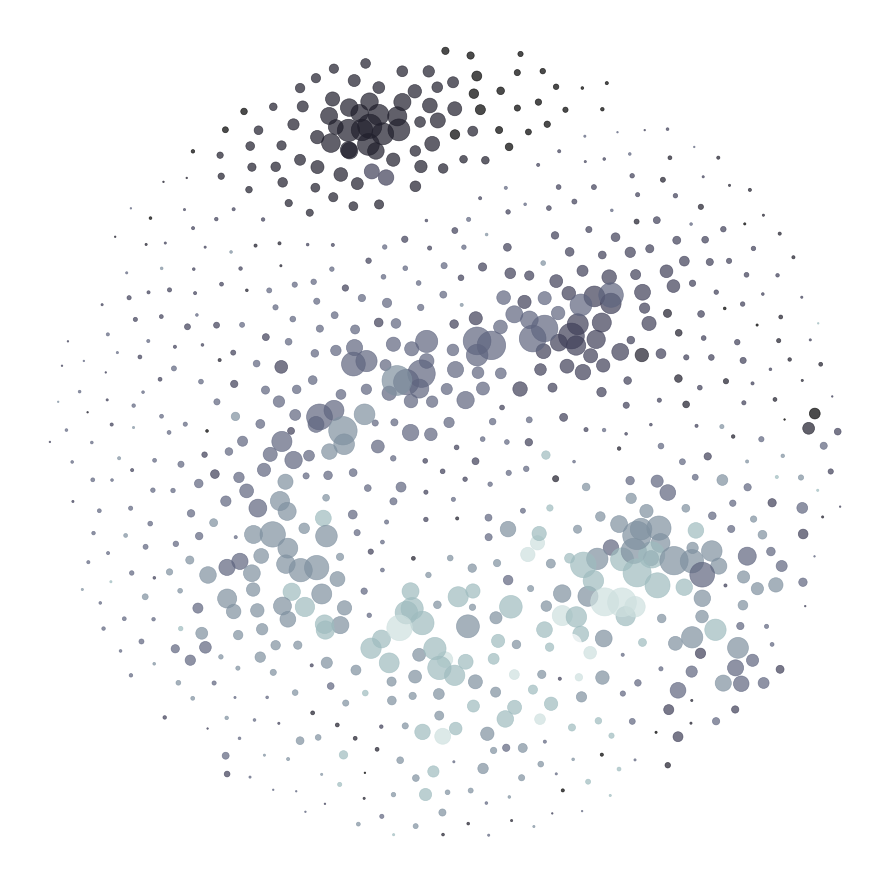

In [9]:
def show(frame, core, **kwargs):
    
    kwargs.setdefault('cmap', 'bone_r')
    kwargs.setdefault('colorbar', False)
    kwargs.setdefault('figsize', (9, 9))
    kwargs.setdefault('grid', False)
    kwargs.setdefault('xticks', [])
    kwargs.setdefault('yticks', []) 
    axes = plot.scatter(frame[frame['degree'].ge(0)], **kwargs)
    axes.set_aspect('equal', 'box')

    return axes
    
axes = show(frame, core)
#axes.figure.savefig(DATADIR / 'brundleverse.png')

In [10]:
#color = dict(zip(range(-1,8), 'kroygbcm'))
#color = degree.map(color).fillna('grey')